In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

In [2]:
crystals = pd.read_csv('./data_c/entry_mention.csv')

## Name Ambiguity

In [49]:
crystals

,entries,mentions,csd_id
0,acetanilide,[2941],ACANIL
1,"2,6-Dimethylphenol",[157226],DMEPOL
2,UPC-33,[508171],METPAF
3,"1-Chloro-2,4-dinitrobenzene","[55124, 55125, 55126, 55127, 55128]",BENCLN
4,tetrahydrate,"[579884, 741350]",OBORUU
...,...,...,...
1441,benzo[e]pyrene,[99355],CEQGEL
1442,3-aminoflavone,[525087],MOVBOP
1443,azetidine,[946358],XATMOV
1444,MCPA,[112522],CMPHAA


In [50]:
target_csd = crystals.csd_id.values

# we have repetitive CSD IDs:
ucsd, csd_cnts = np.unique(target_csd, return_counts=True)

Some of these repetitive CSDs have crystal names that are different only different up to an upper-case letter (e.g., '1,2-dichlorobenzene' and '1,2-Dichlorobenzene' for CSD = 'ABUMIT') and some have names that are more different (e.g., '2,6-Diaminopyridine' and 'pyridine-2,6-diamine' for CSD = 'FOYLEK'). We'll check how many of each of these categories exist:

In [53]:
crystals[crystals.csd_id == "ABEDUJ"]

,entries,mentions,csd_id
761,bosutinib,[518],ABEDUJ


In [14]:
reps = ucsd[csd_cnts > 1]

csd_with_diff_names = []
for csd in reps:
    names = crystals[crystals.csd_id == csd].entries
    #names = D[D['CSD ID'].str.contains(csd)]['chemical name']
    names = [x.lower() for x in names]
    if len(np.unique(names)) > 1:
        print(csd, names)
        csd_with_diff_names += [csd]

ANTQUO ['anthracene-9,10-dione', '9,10-anthraquinone', '9,10-anthraquinone']
BINAPH ["1,1'-binaphthalene", "1,1'-binaphthyl"]
CLANIC ['4-chloroaniline', 'p-chloroaniline']
COTZAN ['acetaminophen', 'paracetamol']
COUMAR ['chromen-2-one', '2h-1-benzopyran-2-one']
COWHUR ['(-)-epicatechin', 'epicatechin']
DANTEN ['bianthrone', 'dianthraquinone']
DNBENZ ['m-dinitrobenzene', '1,3-dinitrobenzene']
DPUREA ['1,3-diphenylurea', "n,n'-diphenylurea"]
DUCKOB ['n-butane', 'butane']
DXYLEN ['[2,2]-paracyclophane', '[2.2]paracyclophane']
ETDIAM ['1,2-diaminoethane', '1,2-ethanediamine']
FLURON ['9-fluorenone', '9h-fluoren-9-one']
FOYLEK ['pyridine-2,6-diamine', '2,6-diaminopyridine']
HIQWEJ ["4,4'-bipyridine", "4,4'-bipyridine", "4,4'-bipyridyl"]
HXQUIN ['quinolin-8-ol', '8-hydroxyquinoline', '8-hydroxyquinoline']
HYQUIN ['benzene-1,4-diol', 'hydroquinone']
JEMPEZ ['v11', 'v101']
NANILI ['4-nitroaniline', 'p-nitroaniline', '4-nitroaniline']
NOZKES ['ethane-1,2-diol', '1,2-ethanediol']
OCHTET ['1,3,5,

In [12]:
D = pd.read_csv('./data_c/crystals_wdoi.csv')

In [ ]:
len(csd_with_diff_names)

For those CSDs with different chemical names, we break the all the corresponding CSDs accordingly. For example, for CSD "DUCKOB" we have the following names:

In [15]:
csd_with_diff_names
crystals[crystals.csd_id == 'DUCKOB'].entries

909     n-Butane
1433      butane
Name: entries, dtype: object

whereas the full set of CSD/names for this ID is the following set:

In [16]:
D[D['CSD ID'].str.contains('DUCKOB')][['CSD ID', 'chemical name']]

,CSD ID,chemical name
167061,DUCKOB,Decadeutero-n-butane
167062,DUCKOB01,Decadeutero-n-butane
167063,DUCKOB02,Decadeutero-n-butane
167064,DUCKOB03,Decadeutero-n-butane
167065,DUCKOB04,n-Butane
167066,DUCKOB05,butane
167067,DUCKOB06,butane
167068,DUCKOB07,butane
167069,DUCKOB08,butane
167070,DUCKOB09,butane


We note that there are three different names associated with this CSD: "Decadeutero-n-butane", "n-Butane" and "butane". Among these, only the last two names exist in our word2vec model. And then there are also combination of these cases:

In [17]:
crystals[crystals.csd_id == csd_with_diff_names[0]]

,entries,mentions,csd_id
234,"anthracene-9,10-dione","[23036, 23037, 23038, 23039, 23040, 23041, 230...",ANTQUO
458,"9,10-anthraquinone",[23035],ANTQUO
847,"9,10-Anthraquinone",[23034],ANTQUO


## Identify CSDs for Names More Accurately
We used to identify CSD of any given name such that all variations of its CSD is also considered. For example, for "DUCKOB", considering all variations of CSD gives us "Decadeutero-n-butane" too, which seems slightly different than "butane" than is included in our word2vec vocabulary.

Hence, here we take each given chemical name, and only consider those CSD variations whose names exactly (up to uppercase letters) match our candidate.

In [18]:
target_names = crystals['entries'].values

In [19]:
D['chemical name'] = D['chemical name'].str.lower()
D['synonyms'] = D['synonyms'].str.lower()

In [20]:
# we do not differ upper- or lower-case letters
target_names = np.unique([x.lower() for x in target_names])

In [22]:
% % time
name2csd = {}
for name in tqdm(target_names):
    csds = D[(D['chemical name'] == name) | (D['synonyms'] == name)]['CSD ID'].values
    name2csd[name] = csds.tolist()

100%|██████████| 1421/1421 [02:08<00:00, 11.04it/s]

CPU times: user 2min 6s, sys: 1.66 s, total: 2min 8s
Wall time: 2min 8s


*Minor Issue:* It seems that some terms are equivalent to each other (this is because we foudn that some CSDs are associated with two names after exact-matching). Here is the list manually compiled:
* "acetaminophen"   & "paracetamol"
* "bianthrone" & "dianthraquinone"
* "hydroquinone" & "benzene-1,4-diol"
* "2-methylphenol" & "o-cresol"
* "s-triazine" & "1,3,5-triazine"
* "m-dinitrobenzene" & "1,3-dinitrobenzene	"

In [185]:
to_remove = ['paracetamol', 'dianthraquinone', 'benzene-1,4-diol', 'o-cresol', '1,3,5-triazine', '1,3-dinitrobenzene']

[name2csd.pop(x) for x in to_remove]

In [225]:
# saving the dictionary
with open("name_to_csd.json", "w") as f:
    json.dump(name2csd, f, indent=True)

## Extracting the Relevant Sub-matrix

In [25]:
# all the CSDs that are involved
target_csds = sum(name2csd.values(), [])

In [29]:
store = pd.HDFStore('./data_c/entry_mention_vs_CSD_AMD100_dm.h5')

In [30]:
# get the first chunk to set up the column-locator
chunk = store.select('df', start=0, stop=100)
cols = chunk.columns
cols_locator = cols.isin(target_csds)

In [217]:
% % time

submat = pd.DataFrame([])

# I already checked it out and saw that the number of rows in the larger matrix is 3926,
# hence we need 39+1=40 iterations (assuming the chunk size is 100)
for i in tqdm(range(40)):
    chunk = store.select('df', start=i * 100, stop=(i + 1) * 100)
    row_locator = chunk.index.isin(target_csds)
    # double check if the order of columns does not change across the chunks
    assert np.all(chunk.columns == cols), "Order of the columns suddenly changed in the {}-th chunk.".format(i)
    # get the submatrix in the chunk and append it to the previous submatrices
    sub_chunk = chunk.iloc[row_locator, cols_locator]
    submat = pd.concat((submat, sub_chunk), axis=0)

100%|███████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]

CPU times: user 1min 4s, sys: 18.3 s, total: 1min 23s
Wall time: 1min 23s


In [218]:
submat.shape

(2658, 3064)

In [ ]:
submat.to_csv('mst_dists_submatrix.csv')

# Compute the Similarity Matrix

In [2]:
submat = pd.read_csv('./data_c/mst_dists_submatrix.csv')
submat.index = list(submat['Unnamed: 0'])
submat.drop(columns='Unnamed: 0', inplace=True)
submat

,ABIREM,ABUMIT,ABUMIT01,ABUMOZ,ABUMOZ01,ABUMOZ02,ABUMOZ03,ABUMOZ04,ABUMOZ05,ABUMOZ06,...,ZAMRIS01,ZAMRIS02,ZAMRIS03,ZAMSEP,ZAMSEP01,ZAMSEP02,ZAMSEP03,ZOGROF01,ZOGROF02,ZOYLII15
ACANIL,0.147719,0.740934,0.714968,0.794301,0.766036,0.678040,0.610771,0.573940,0.489780,0.461020,...,0.644621,0.572505,0.565113,0.458489,0.461380,0.455188,0.454861,1.303028,1.365292,0.094109
ACANIL01,0.109256,0.823257,0.798499,0.883535,0.850319,0.766803,0.699711,0.664163,0.577626,0.552211,...,0.728399,0.663161,0.655770,0.517233,0.513891,0.508295,0.508317,1.387830,1.450095,0.086162
ACANIL02,0.159793,0.852137,0.826805,0.901732,0.869897,0.789759,0.717908,0.682431,0.597171,0.567432,...,0.735640,0.659888,0.652096,0.464502,0.456971,0.450780,0.450452,1.403503,1.469004,0.093638
ACANIL03,0.127033,0.743361,0.718100,0.804902,0.773959,0.691923,0.621077,0.585530,0.501172,0.472413,...,0.653233,0.583272,0.575880,0.480771,0.483662,0.477470,0.477142,1.309473,1.371738,0.083014
ACANIL04,0.137717,0.757324,0.729058,0.793515,0.762769,0.678887,0.613481,0.580300,0.497479,0.468719,...,0.651822,0.584064,0.571457,0.494588,0.486705,0.485651,0.485672,1.330795,1.393059,0.080850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOVBOP02,0.141334,0.734413,0.707115,0.781170,0.752905,0.664909,0.598570,0.565389,0.482568,0.453808,...,0.646935,0.563154,0.553196,0.498515,0.490632,0.489578,0.489600,1.277088,1.340662,0.106110
XATMOV,0.295053,1.060905,1.037765,1.119136,1.088144,0.993355,0.917164,0.881672,0.792226,0.763455,...,0.923077,0.835107,0.819423,0.626609,0.602785,0.601731,0.601752,1.656759,1.716844,0.342289
XATMOV01,0.290810,1.056231,1.034406,1.114413,1.081067,0.986278,0.910087,0.875467,0.785149,0.756378,...,0.916001,0.832849,0.817585,0.624694,0.588224,0.563951,0.560656,1.650182,1.709767,0.335212
CMPHAA01,0.207295,0.678903,0.641646,0.725469,0.691470,0.609106,0.539952,0.503248,0.420346,0.394931,...,0.599725,0.524200,0.511551,0.463055,0.455172,0.454117,0.454139,1.198917,1.259247,0.166163


In [3]:
def get_euler_similar(i, j):
    return np.sqrt(np.sum(np.square(i - j)))


def get_cos_similar(v1, v2):
    num = float(np.dot(v1, v2))  # 向量点乘
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)  # 求模长的乘积
    return 0.5 + 0.5 * (num / denom) if denom != 0 else 0

In [4]:
name2csd = json.load(open('./data_c/name_to_csd.json'))
ch_names = list(name2csd.keys())
ch_names

['(+)-aspidospermidine',
 '(+)-goniofufurone',
 '(+)-hopeaphenol',
 '(-)-adrenaline',
 '(-)-deoxypodophyllotoxin',
 '(-)-epicatechin',
 '(-)-hopeaphenol',
 '(-)-jiadifenolide',
 '(-)-lobeline',
 '(-)-noradrenaline',
 '(-)-phenylephrine',
 '(-)-rhazinilam',
 '(-)-syringaresinol',
 '(1-pentyl-1h-indol-3-yl)(2,2,3,3-tetramethylcyclopropyl)methanone',
 '(2-nitrophenyl)methanol',
 '(e)-stilbene',
 '(r)-flurbiprofen',
 '(s)-naproxen',
 '(s)-oxiracetam',
 '-iron',
 '.',
 '1',
 "1,1'-binaphthalene",
 "1,1'-binaphthalene-2,2'-diol",
 "1,1'-binaphthyl",
 "1,1'-biphenyl",
 '1,1,1,2-tetrafluoroethane',
 '1,1,1,3,3,3-hexafluoro-2-propanol',
 '1,1,1,3,3,3-hexafluoropropan-2-ol',
 '1,1,1-trichloro-2,2-bis(4-chlorophenyl)ethane',
 '1,1,1-trichloroethane',
 '1,1,1-trifluoro-2-iodoethane',
 '1,1,2,2-tetrachloroethane',
 '1,1,2,3,4,5-hexaphenylsilole',
 '1,1,2-trichloroethane',
 '1,1-dichloro-2,2-bis(p-chlorophenyl)ethylene',
 '1,1-dichloroethane',
 '1,12-diazaperylene',
 '1,2,3,4,5,6-hexachlorocyclohexa

In [5]:
w2v_md = Word2Vec.load('./models/pubMed.model')

In [6]:
ch_names_exi = []
for nm in ch_names:
    if submat.index.isin(name2csd[nm]).sum():
        ch_names_exi.append(nm)
    else:
        print(nm, name2csd[nm])

(+)-goniofufurone ['EWECUG', 'UZAKAJ01']
-iron ['KCROFE01']
1,2,3-triazole ['RUVQOO']
1,2-diiodobenzene ['ZZZGFW']
1,2-ethanediol ['NOZKES01']
1,2-naphthoquinone ['ZZZJIE']
1,3,5-trimethylbenzene ['SOPLAL01']
1,4-diazepane ['AREBUX']
1-kestose ['KESTOS']
11-dehydrosinulariolide ['AWIZOW']
1h-indole ['INDOLE03']
1h-pyrrolo[3,2-h]quinoline ['JOPKEE02']
2,3,4,9-tetrahydro-1h-carbazole ['LOJCIX', 'LOJCIX01', 'LOJCIX02']
2,3,4-trimethoxy-4'-acetyl-1,1'-biphenyl ['ANEDEF']
2-amino-2-(hydroxymethyl)propane-1,3-diol ['THXMAM05', 'THXMAM06', 'THXMAM07', 'THXMAM10', 'THXMAM12']
2-amino-4,6-dinitrotoluene ['ISAXUV']
2-aminoanthraquinone ['YUYNAH']
2-chloro-4,6-dimethoxy-1,3,5-triazine ['EMIJEP', 'EPURIT']
2-chlorothiophene ['KOQCOL']
2-fluoroaniline ['IDAHOL']
2-hydroxybiphenyl ['FIFMAI']
2-methylnaphthalene ['QQQCSV03', 'QQQCSV10']
2-naphthol ['NAPHOB02']
2-phenylquinoline ['FURSOD']
2c ['NADPUF']
3,5-dimethyl-1h-pyrazole ['DASXEA11']
3,5-diphenyl-1h-pyrazole ['LADBIB05', 'LADBIB07', 'LADBIB08']

In [7]:
ch_names_exc = []
for nm in ch_names:
    if submat.columns.isin(name2csd[nm]).sum():
        ch_names_exc.append(nm)
    else:
        print(nm, name2csd[nm])

(+)-goniofufurone ['EWECUG', 'UZAKAJ01']
-iron ['KCROFE01']
1,2,3-triazole ['RUVQOO']
1,2-diiodobenzene ['ZZZGFW']
1,2-ethanediol ['NOZKES01']
1,2-naphthoquinone ['ZZZJIE']
1,3,5-trimethylbenzene ['SOPLAL01']
1,4-diazepane ['AREBUX']
1-kestose ['KESTOS']
11-dehydrosinulariolide ['AWIZOW']
1h-indole ['INDOLE03']
1h-pyrrolo[3,2-h]quinoline ['JOPKEE02']
2,3,4,9-tetrahydro-1h-carbazole ['LOJCIX', 'LOJCIX01', 'LOJCIX02']
2,3,4-trimethoxy-4'-acetyl-1,1'-biphenyl ['ANEDEF']
2-amino-2-(hydroxymethyl)propane-1,3-diol ['THXMAM05', 'THXMAM06', 'THXMAM07', 'THXMAM10', 'THXMAM12']
2-amino-4,6-dinitrotoluene ['ISAXUV']
2-aminoanthraquinone ['YUYNAH']
2-chloro-4,6-dimethoxy-1,3,5-triazine ['EMIJEP', 'EPURIT']
2-chlorothiophene ['KOQCOL']
2-fluoroaniline ['IDAHOL']
2-hydroxybiphenyl ['FIFMAI']
2-methylnaphthalene ['QQQCSV03', 'QQQCSV10']
2-naphthol ['NAPHOB02']
2-phenylquinoline ['FURSOD']
2c ['NADPUF']
3,5-dimethyl-1h-pyrazole ['DASXEA11']
3,5-diphenyl-1h-pyrazole ['LADBIB05', 'LADBIB07', 'LADBIB08']

In [8]:
len(ch_names), len(ch_names_exi), len(ch_names_exc)

(1415, 1092, 1104)

In [10]:
crystals = pd.read_csv('./data_c/entry_mention.csv')
ch_names_check_i = []
for nm in ch_names_exi:
    if nm in crystals['entries']:
        ch_names_check_i.append(nm)
    else:
        ch_names_check_i.append(nm.lower())
ch_names_check_c = []
for nm in ch_names_exc:
    if nm in crystals['entries']:
        ch_names_check_c.append(nm)
    else:
        ch_names_check_c.append(nm.lower())

In [155]:
%%time
str_simi_df = pd.DataFrame(columns=ch_names_exi, index=ch_names_exc)
semi_simi_df = pd.DataFrame(columns=ch_names_exi, index=ch_names_exc)
for i in tqdm(range(len(ch_names_exc))):
    i_df = submat.iloc[:, submat.columns.isin(name2csd[ch_names_exc[i]])]
    i_vec = w2v_md.wv[ch_names_check_c[i]].reshape((-1))
    for j in range(len(ch_names_exi)):
        ij_df = i_df[i_df.index.isin(name2csd[ch_names_exi[j]])]
        j_vec = w2v_md.wv[ch_names_check_i[j]].reshape((-1))

        struct_tube = (np.array(ij_df).max(), np.array(ij_df).min(), np.array(ij_df).mean())
        #print(struct_tube)
        str_simi_df.loc[ch_names_exc[i], ch_names_exi[j]] = struct_tube

        semi_tube = (get_euler_similar(i_vec, j_vec), get_cos_similar(i_vec, j_vec))
        #print(semi_tube)
        semi_simi_df.loc[ch_names_exc[i], ch_names_exi[j]] = semi_tube

100%|██████████| 1104/1104 [07:39<00:00,  2.40it/s]

CPU times: user 7min 35s, sys: 5.64 s, total: 7min 41s
Wall time: 7min 39s


In [156]:
str_simi_df.to_csv('./data_c/structure_simi.csv')
semi_simi_df.to_csv('./data_c/semantic_simi.csv')

In [19]:
str_simi_df=pd.read_csv('./data_c/structure_simi.csv',index_col="Unnamed: 0")
semi_simi_df=pd.read_csv('./data_c/semantic_simi.csv',index_col="Unnamed: 0")

In [20]:
def scatter_matrix(semantic, struct, m=1, thre=0):
    idx = [nm.lower() for nm in ch_names_check_i if w2v_md.wv.vocab[nm].count >= thre]
    col = [nm.lower() for nm in ch_names_check_c if w2v_md.wv.vocab[nm].count >= thre]
    semantic_thre = semantic.loc[col, idx]
    struct_thre = struct.loc[col, idx]

    scatter_x = []
    scatter_y = []
    for i in range(len(semantic_thre.index)):
        for j in range(min(i, len(semantic_thre.columns))):
            scatter_y.append(float(semantic_thre.iloc[i, j][1]))
            scatter_x.append(float(struct_thre.iloc[i, j][m]))

    if m == 1:
        mode = "minimum"
    elif m == 0:
        mode = "maximun"
    else:
        mode = "average"

    plt.title(f"threshod {thre} with {mode} distances")
    plt.ylabel("Semantic similarity by cosine")
    plt.xlabel("Structural similariy")
    plt.scatter(-np.array(scatter_x), scatter_y)
    print(spearmanr(-np.array(scatter_x), scatter_y))
    print(pearsonr(-np.array(scatter_x), scatter_y))
    plt.show()

SpearmanrResult(correlation=0.06521604030180217, pvalue=0.0)
(0.051478264842032065, 0.0)


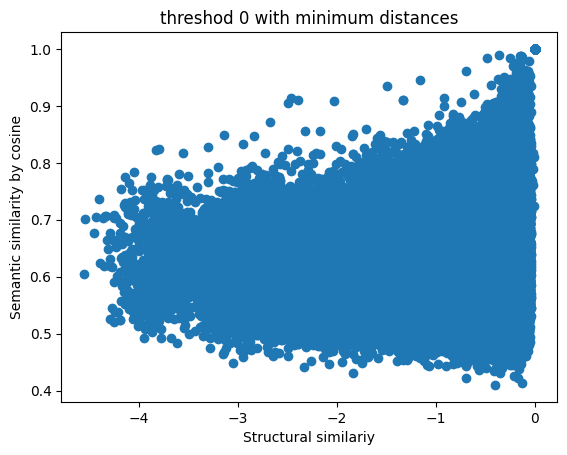

In [182]:
scatter_matrix(semi_simi_df, str_simi_df, m=1)

SpearmanrResult(correlation=-0.015142914086450064, pvalue=3.230272492084795e-32)
(-0.008146181562841755, 2.0687270483127543e-10)


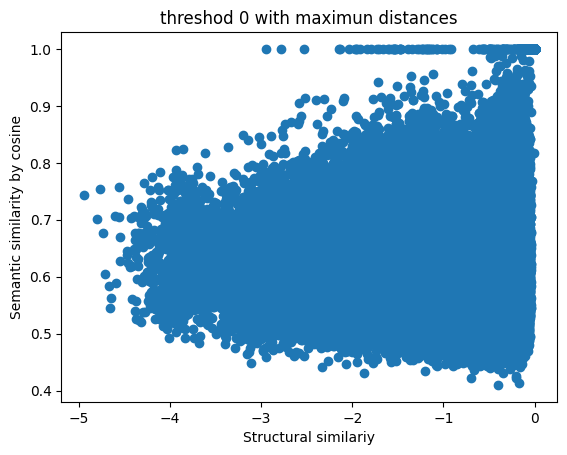

In [183]:
scatter_matrix(semi_simi_df, str_simi_df, m=0)

SpearmanrResult(correlation=0.020167770337498964, pvalue=8.372466043424791e-56)
(0.030770613529354954, 1.9665323095565687e-127)


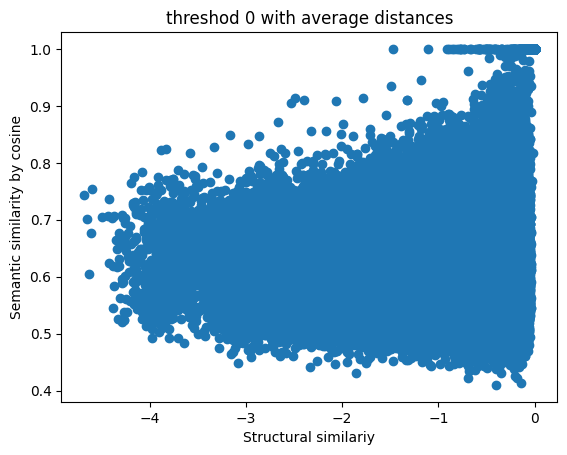

In [184]:
scatter_matrix(semi_simi_df, str_simi_df, m=2)

SpearmanrResult(correlation=0.05579512666698743, pvalue=1.598342304877972e-216)
(0.04135817638411318, 8.390498896287842e-120)


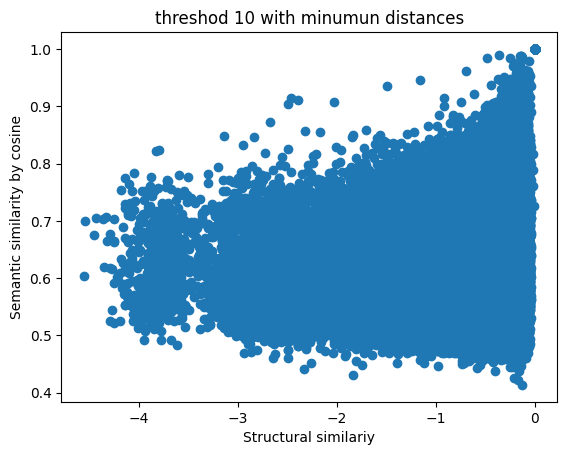

In [173]:
scatter_matrix(semi_simi_df, str_simi_df, m=1, thre=10)

SpearmanrResult(correlation=-0.04877833784899504, pvalue=6.459622718898722e-166)
(-0.03807236280042103, 8.280830560349923e-102)


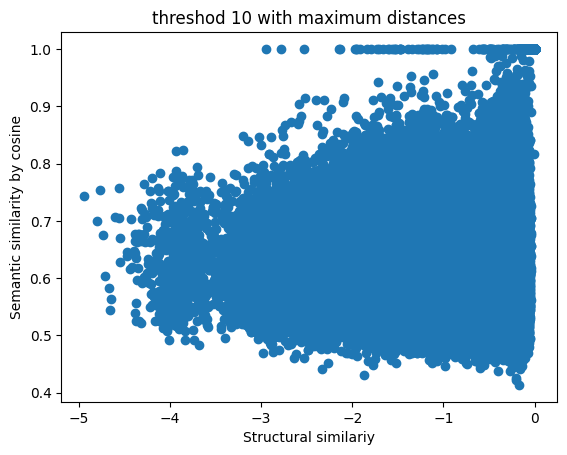

In [176]:
scatter_matrix(semi_simi_df, str_simi_df, m=0, thre=10)

SpearmanrResult(correlation=-0.0053303059346691455, pvalue=0.0027162062119387765)
(0.011482468238345306, 1.0557372324033624e-10)


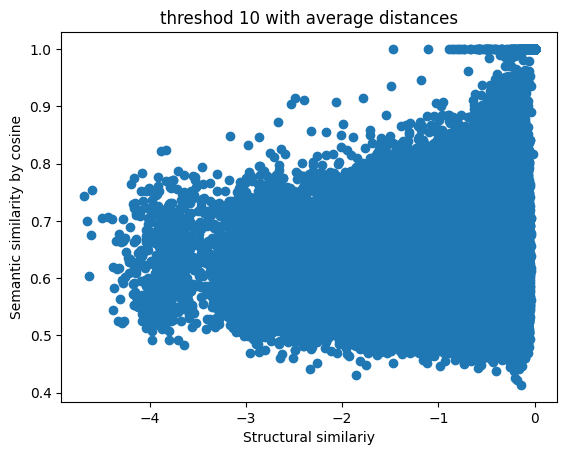

In [177]:
scatter_matrix(semi_simi_df, str_simi_df, m=2, thre=10)

SpearmanrResult(correlation=0.06917411076597409, pvalue=4.443154889223083e-95)
(0.03421113640695504, 1.5754802993166864e-24)


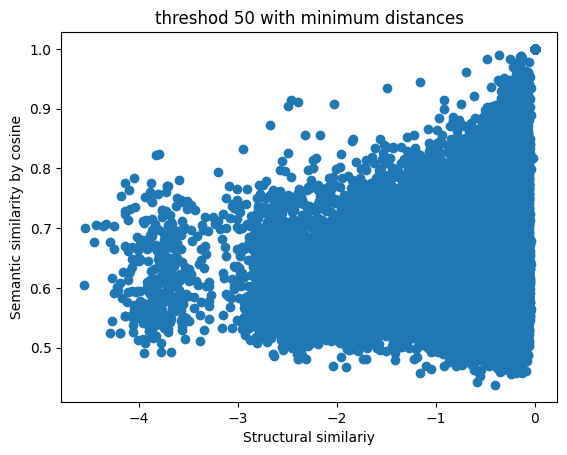

In [185]:
scatter_matrix(semi_simi_df, str_simi_df, m=1,thre=50)

SpearmanrResult(correlation=-0.07486162967953532, pvalue=4.546337643708861e-111)
(-0.0658741279004041, 2.2052708308075013e-86)


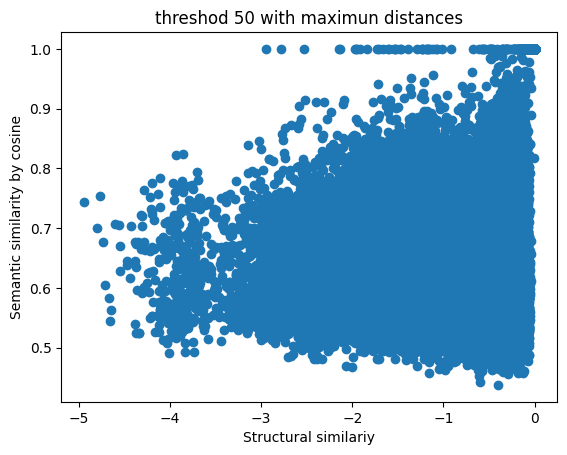

In [186]:
scatter_matrix(semi_simi_df, str_simi_df, m=0,thre=50)

SpearmanrResult(correlation=-0.022572534496739682, pvalue=1.54541181044675e-11)
(-0.007743435641601246, 0.020717134531719587)


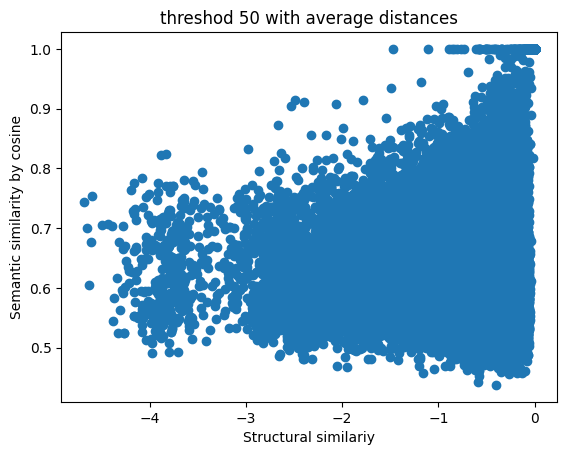

In [187]:
scatter_matrix(semi_simi_df, str_simi_df, m=2,thre=50)

SpearmanrResult(correlation=0.07021984631831416, pvalue=2.3022266713621944e-61)
(0.03386742767195833, 1.6650089606275089e-15)


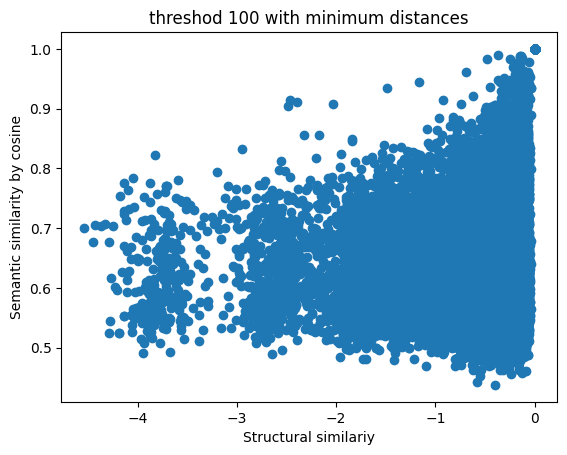

In [188]:
scatter_matrix(semi_simi_df, str_simi_df, m=1,thre=100)

SpearmanrResult(correlation=-0.08092762141942059, pvalue=5.833575122014886e-81)
(-0.06316789643268263, 5.58283561412227e-50)


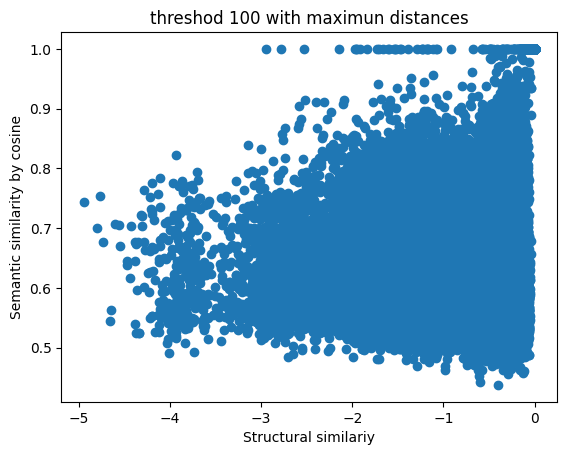

In [189]:
scatter_matrix(semi_simi_df, str_simi_df, m=0,thre=100)

SpearmanrResult(correlation=-0.02754666156756375, pvalue=9.352221481678361e-11)
(-0.006384813267713077, 0.1333564680303215)


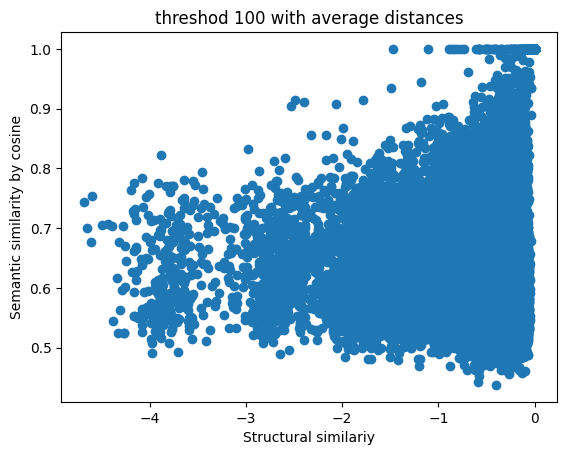

In [190]:
scatter_matrix(semi_simi_df, str_simi_df, m=2,thre=100)